In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from scipy.sparse import save_npz
import warnings
warnings.filterwarnings('ignore')

In [2]:


dataset_credits = pd.read_csv("tmdb_5000_credits.csv")
dataset_movies = pd.read_csv("tmdb_5000_movies.csv")
     

df_credits = dataset_credits.copy(deep=True)
df_movies = dataset_movies.copy(deep=True)
     


In [3]:
df_credits.head(2)

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."


In [4]:
df_credits = df_credits.drop(columns=["title"], axis=1)
df_movies = pd.concat([df_movies, df_credits], axis = 1)

In [5]:
df_movies.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,movie_id,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,19995,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,285,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."


In [6]:

df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

In [7]:

df_movies["status"].value_counts()

Released           4795
Rumored               5
Post Production       3
Name: status, dtype: int64

In [8]:


df_movies = df_movies.drop(df_movies[df_movies['status'] == "Rumored"].index, axis=0)
df_movies = df_movies.drop(df_movies[df_movies["status"] == "Post Production"].index, axis=0)
df_movies = df_movies.drop(columns=["status", "homepage", "id", "original_title", 
                                    "overview", "spoken_languages", 
                                    "tagline", "production_countries", "original_language"], axis=1)

In [9]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4795 entries, 0 to 4802
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4795 non-null   int64  
 1   genres                4795 non-null   object 
 2   keywords              4795 non-null   object 
 3   popularity            4795 non-null   float64
 4   production_companies  4795 non-null   object 
 5   release_date          4794 non-null   object 
 6   revenue               4795 non-null   int64  
 7   runtime               4793 non-null   float64
 8   title                 4795 non-null   object 
 9   vote_average          4795 non-null   float64
 10  vote_count            4795 non-null   int64  
 11  movie_id              4795 non-null   int64  
 12  cast                  4795 non-null   object 
 13  crew                  4795 non-null   object 
dtypes: float64(3), int64(4), object(7)
memory usage: 561.9+ KB


In [10]:
df_movies.describe()

,budget,popularity,revenue,runtime,vote_average,vote_count,movie_id
count,4.795000e+03,4795.000000,4.795000e+03,4793.000000,4795.000000,4795.000000,4795.000000
mean,2.909267e+07,21.527415,8.239771e+07,106.915084,6.093306,691.360792,57051.887800
std,4.073962e+07,31.831547,1.629583e+08,22.570343,1.190313,1235.298140,88593.489117
min,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,5.000000
25%,8.000000e+05,4.723880,0.000000e+00,94.000000,5.600000,54.000000,9010.500000
50%,1.500000e+07,12.963328,1.925587e+07,104.000000,6.200000,236.000000,14585.000000
75%,4.000000e+07,28.352222,9.311911e+07,118.000000,6.800000,738.000000,58533.000000
max,3.800000e+08,875.581305,2.787965e+09,338.000000,10.000000,13752.000000,459488.000000


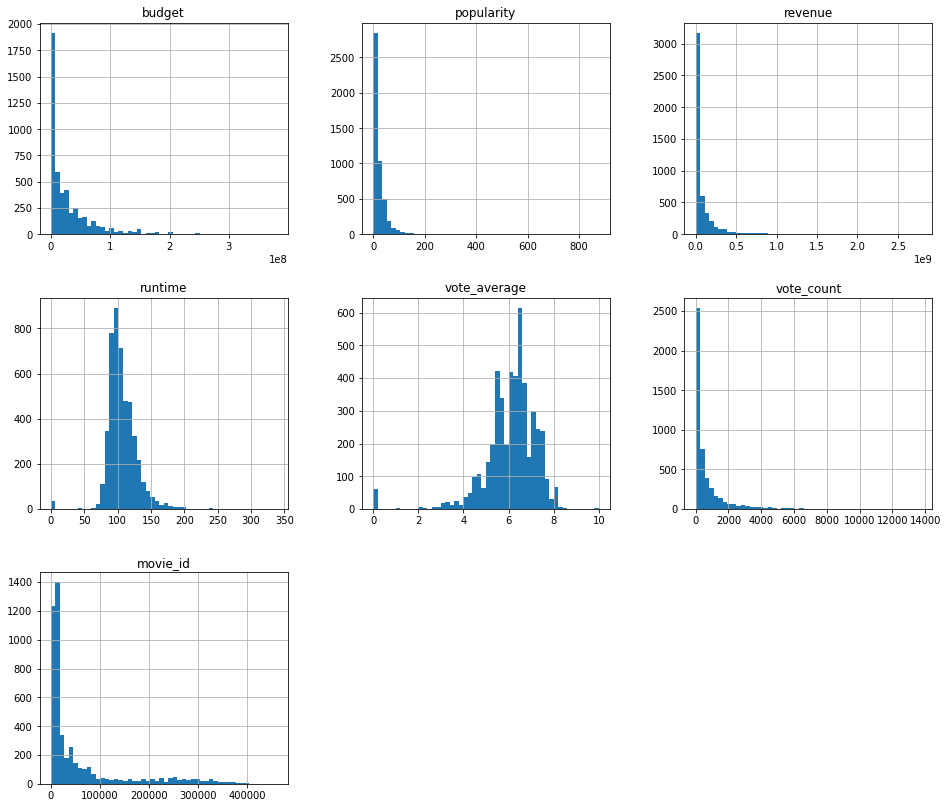

In [11]:
df_movies.hist(bins = 50, figsize = (16, 14), ) #this method shows the histograms for each numerical attribute
plt.show()

In [12]:
sum(df_movies.duplicated())

0

In [13]:
df_movies.isna().sum()

budget                  0
genres                  0
keywords                0
popularity              0
production_companies    0
release_date            1
revenue                 0
runtime                 2
title                   0
vote_average            0
vote_count              0
movie_id                0
cast                    0
crew                    0
dtype: int64

In [14]:
df_movies = df_movies.dropna(axis = 0)

In [15]:
df_movies["genres"][1]

'[{"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 28, "name": "Action"}]'

In [16]:
genre_list = ['Adventure', 'Science Fiction', 'Fantasy', 'Crime',
              'Western', 'Family', 'Animation','War',
              'Mystery','Romance','TV Movie','Action', 'Thriller',
              'Comedy','Drama' , 'History', 'Music', 'Horror', 'Documentary', 'Foreign']

def assign_genre(genres):
  if (element in genres):
    return True
  else:
    return False


for element in genre_list:
  df_movies[element] = df_movies["genres"].apply(assign_genre)

df_movies.head(2)

,budget,genres,keywords,popularity,production_companies,release_date,revenue,runtime,title,vote_average,...,TV Movie,Action,Thriller,Comedy,Drama,History,Music,Horror,Documentary,Foreign
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",2009-12-10,2787965087,162.0,Avatar,7.2,...,False,True,False,False,False,False,False,False,False,False
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",2007-05-19,961000000,169.0,Pirates of the Caribbean: At World's End,6.9,...,False,True,False,False,False,False,False,False,False,False


In [17]:
df_movies['release_date'] = pd.to_datetime(df_movies['release_date'])
df_movies['year'] = df_movies['release_date'].dt.year
df_movies = df_movies.drop("release_date", axis = 1)

In [18]:
def extract_director(crew):
  if (crew  == "[]"):
    return None
  mylist = crew[crew.find("Director\""):crew.find("}", crew.find("Director\""))].split("\"")
  if (mylist[0] != "Director"):
    return None
  else:
    return mylist[4]

df_movies["director"] = df_movies["crew"].apply(extract_director)
# df_movies[df_movies["director"][0] != "Director"]
df_movies = df_movies.dropna(subset = ["director"])
df_movies.drop("crew", axis = 1, inplace = True)

In [19]:
def assign_director_movie_count(col, dir_df):
  return dir_df[dir_df.index == col][0]

movie_counts = df_movies["director"].value_counts()
df_movies["director_movie_count"] = df_movies["director"].apply(assign_director_movie_count, dir_df = movie_counts)

In [20]:
df_movies['cast'][1]

'[{"cast_id": 4, "character": "Captain Jack Sparrow", "credit_id": "52fe4232c3a36847f800b50d", "gender": 2, "id": 85, "name": "Johnny Depp", "order": 0}, {"cast_id": 5, "character": "Will Turner", "credit_id": "52fe4232c3a36847f800b511", "gender": 2, "id": 114, "name": "Orlando Bloom", "order": 1}, {"cast_id": 6, "character": "Elizabeth Swann", "credit_id": "52fe4232c3a36847f800b515", "gender": 1, "id": 116, "name": "Keira Knightley", "order": 2}, {"cast_id": 12, "character": "William \\"Bootstrap Bill\\" Turner", "credit_id": "52fe4232c3a36847f800b52d", "gender": 2, "id": 1640, "name": "Stellan Skarsg\\u00e5rd", "order": 3}, {"cast_id": 10, "character": "Captain Sao Feng", "credit_id": "52fe4232c3a36847f800b525", "gender": 2, "id": 1619, "name": "Chow Yun-fat", "order": 4}, {"cast_id": 9, "character": "Captain Davy Jones", "credit_id": "52fe4232c3a36847f800b521", "gender": 2, "id": 2440, "name": "Bill Nighy", "order": 5}, {"cast_id": 7, "character": "Captain Hector Barbossa", "credit_

In [21]:
from ast import literal_eval
df_movies = df_movies.drop(df_movies[df_movies['cast'] == "[]"].index, axis=0)
df_movies['cast'] = df_movies['cast'].apply(literal_eval)
df_movies['cast_size'] = df_movies['cast'].apply(lambda x: len(x))

df_movies['cast'] = df_movies['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
df_movies['cast'] = df_movies['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)

In [22]:
cast_list = ["cast_1", "cast_2", "cast_3"]

def extract_cast(cast, i):
  if (len(cast) > i):
    return cast[i]
  else:
    return None

n = 0
for cast in cast_list:
  df_movies[cast] = df_movies["cast"].apply(extract_cast, i = n)
  n += 1;

df_movies = df_movies.dropna(subset = ["cast_2", "cast_3"])
df_movies.drop(["cast"], inplace = True, axis = 1)

In [23]:
def assign_director_movie_count(col, dir_df):
  return dir_df[dir_df.index == col][0]


In [24]:
movie_counts = df_movies["director"].value_counts()
df_movies["director_movie_count"] = df_movies["director"].apply(assign_director_movie_count,
                                                                dir_df = movie_counts)
     

In [25]:
def assign_cast_movie_count(row, cast_df_1, cast_df_2, cast_df_3):
  cast_list = ["cast_1", "cast_2", "cast_3"]
  sum = 0
  for c in cast_list:
    if (row[c] in cast_df_1):
      sum += cast_df_1[row[c]]
    if (row[c] in cast_df_2):
      sum += cast_df_2[row[c]]
    if (row[c] in cast_df_3):
      sum += cast_df_3[row[c]]
  return sum

In [26]:
cast1_df = df_movies["cast_1"].value_counts()
cast2_df = df_movies["cast_2"].value_counts()
cast3_df = df_movies["cast_3"].value_counts()
     

In [27]:
df_movies["cast_movie_count"] = df_movies.apply(assign_cast_movie_count,
                                                cast_df_1 = cast1_df, cast_df_2 = cast2_df,
                                                cast_df_3 = cast3_df, axis=1)

In [28]:
df_movies = df_movies.drop(df_movies[df_movies['production_companies'] == "[]"].index, axis=0)
df_movies['production_companies'] = df_movies['production_companies'].apply(literal_eval)

df_movies['production_companies'] = df_movies['production_companies'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
df_movies['production_companies'] = df_movies['production_companies'].apply(lambda x: x[:3] if len(x) >=3 else x)


In [29]:
prod_list = ["production_companies_1", "production_companies_2", "production_companies_3"]

def extract_prod(prod, i):
  if (len(prod) > i):
    return prod[i]
  else:
    return None

n = 0
for prod in prod_list:
  df_movies[prod] = df_movies["production_companies"].apply(extract_prod, i = n)
  n += 1;


In [30]:
#df_movies = df_movies.dropna(subset = ["production_companies_2", "production_companies_3"])
df_movies.drop(["production_companies"], inplace = True, axis = 1)
     

In [31]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4431 entries, 0 to 4802
Data columns (total 41 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   budget                  4431 non-null   int64  
 1   genres                  4431 non-null   object 
 2   keywords                4431 non-null   object 
 3   popularity              4431 non-null   float64
 4   revenue                 4431 non-null   int64  
 5   runtime                 4431 non-null   float64
 6   title                   4431 non-null   object 
 7   vote_average            4431 non-null   float64
 8   vote_count              4431 non-null   int64  
 9   movie_id                4431 non-null   int64  
 10  Adventure               4431 non-null   bool   
 11  Science Fiction         4431 non-null   bool   
 12  Fantasy                 4431 non-null   bool   
 13  Crime                   4431 non-null   bool   
 14  Western                 4431 non-null   

In [32]:
df_movies.drop(["production_companies_2"], inplace = True, axis = 1)
df_movies.drop(["production_companies_3"], inplace = True, axis = 1)

In [33]:
v = df_movies["vote_count"]
R = df_movies["vote_average"]
c = df_movies["vote_average"].mean()
m = df_movies["vote_count"].quantile(0.7)

df_movies["weighted_average"] = (R * v + c * m) / (v + m)

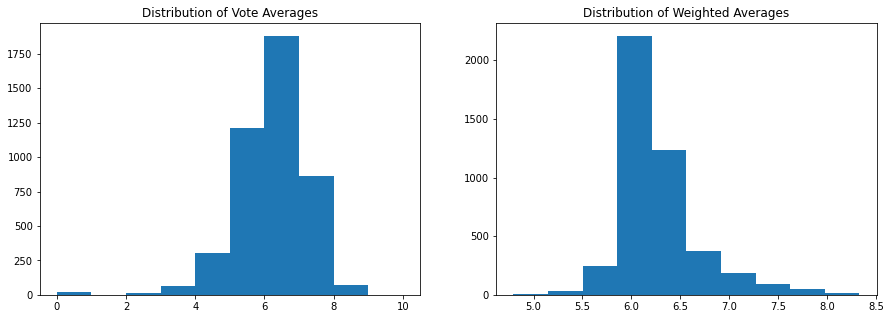

In [34]:
fig, ax = plt.subplots(1,2, figsize=(15, 5))
ax[0].hist(df_movies["vote_average"])
ax[0].set_title("Distribution of Vote Averages")

ax[1].hist(df_movies["weighted_average"])
ax[1].set_title("Distribution of Weighted Averages")
plt.show()

In [35]:
X_train=df_movies.copy()

In [36]:

X_train.head(2)

,budget,genres,keywords,popularity,revenue,runtime,title,vote_average,vote_count,movie_id,...,year,director,director_movie_count,cast_size,cast_1,cast_2,cast_3,cast_movie_count,production_companies_1,weighted_average
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",150.437577,2787965087,162.0,Avatar,7.2,11800,19995,...,2009,James Cameron,7,83,Sam Worthington,Zoe Saldana,Sigourney Weaver,36,Ingenious Film Partners,7.146547
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",139.082615,961000000,169.0,Pirates of the Caribbean: At World's End,6.9,4500,285,...,2007,Gore Verbinski,7,34,Johnny Depp,Orlando Bloom,Keira Knightley,56,Walt Disney Pictures,6.808643


In [37]:
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
X_train_clean = X_train.copy()

numerical_list = ['revenue', 'popularity','budget', 'runtime', 'vote_count', "weighted_average", "vote_average", "director_movie_count", "cast_movie_count"]


X_train_clean.loc[:, ("budget")] = X_train["budget"].replace(0, X_train["budget"].mean())
Q1 = X_train_clean["budget"].quantile(0.25)
Q3 = X_train_clean["budget"].quantile(0.75)
IQR = Q3 - Q1
X_train_clean=X_train.loc[(X_train["budget"] >=Q1- 1.5*IQR) & (X_train["budget"]<=Q3+ 1.5*IQR)]



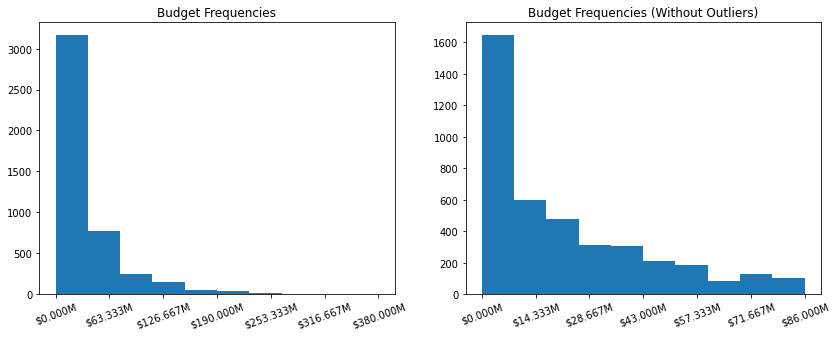

In [38]:
max=X_train["budget"].max()
max_clean=X_train_clean["budget"].max()

fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (14,5))

ax1.hist(X_train["budget"])
ax2.hist([X_train_clean["budget"]])

xlocs = np.linspace(0, max ,7)
xlocs_clean = np.linspace(0, max_clean ,7)
xticks_labels = [f"${xloc/10**6:.3f}M" for xloc in xlocs]
xticks_labels_clean = [f"${xloc/10**6:.3f}M" for xloc in xlocs_clean]


ax1.set_title("Budget Frequencies")
ax1.set_xticks(xlocs)
ax1.set_xticklabels(xticks_labels, rotation=20)

ax2.set_xticks(xlocs_clean)
ax2.set_xticklabels(xticks_labels_clean, rotation=20)
ax2.set_title("Budget Frequencies (Without Outliers)")

plt.show()

In [39]:
for genre in genre_list:
  print(genre, X_train_clean[(X_train_clean[genre] == True)].shape)

Adventure (540, 40)
Science Fiction (409, 40)
Fantasy (306, 40)
Crime (641, 40)
Western (74, 40)
Family (385, 40)
Animation (161, 40)
War (129, 40)
Mystery (314, 40)
Romance (814, 40)
TV Movie (7, 40)
Action (886, 40)
Thriller (1116, 40)
Comedy (1501, 40)
Drama (2026, 40)
History (174, 40)
Music (175, 40)
Horror (481, 40)
Documentary (63, 40)
Foreign (16, 40)


In [40]:
def categorize_budget(budget):
  if budget < 2.909267e+07:
    return 'Low'
  elif 2.909267e+07 <= budget <= 42268587.8827761	:
    return 'Medium'
  else:
    return 'High'


X_train_clean['Budget Category'] = X_train_clean['budget'].astype(int).apply(categorize_budget)

duration_groups = X_train_clean.groupby(by = 'Budget Category')

value_dict = {}
for key, vals in duration_groups.groups.items():
  value_dict[key] = X_train_clean.loc[vals]['vote_average'].dropna().values

C:\Users\Mohit Sai Kiran\AppData\Local\Temp\ipykernel_1012\3102384103.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_clean['Budget Category'] = X_train_clean['budget'].astype(int).apply(categorize_budget)


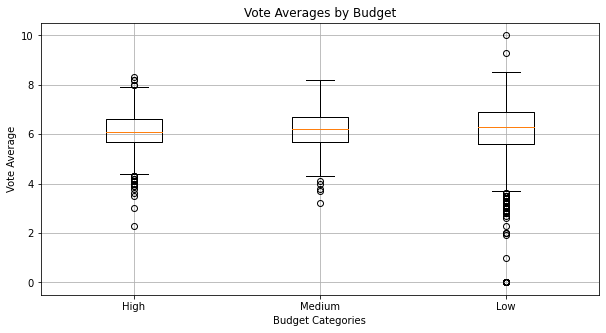

In [41]:
ratings = sorted(value_dict.items(), key=lambda x: np.median(x[1]))
fig, ax = plt.subplots(figsize=(10,5))

ax.boxplot([val[1] for val in ratings])
ax.set_xticklabels([rating[0] for rating in ratings])
ax.set_ylabel('Vote Average')
ax.set_xlabel('Budget Categories')
ax.set_title('Vote Averages by Budget')
ax.grid()
plt.show();

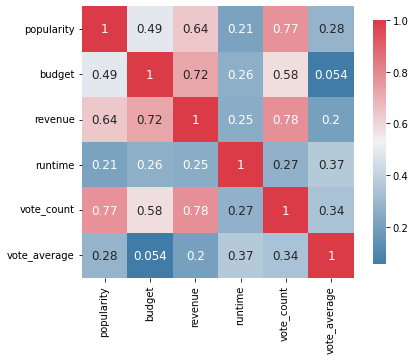

In [42]:
import seaborn as sns
corr = df_movies[['popularity','budget','revenue','runtime','vote_count','vote_average']].corr()
_, ax = plt.subplots(figsize = (7,5))
cmap = sns.diverging_palette( 240 , 10 , as_cmap = True )
_ = sns.heatmap(corr,cmap = cmap,square=True, cbar_kws={ 'shrink' : .9 }, ax=ax, annot = True, annot_kws = { 'fontsize' : 12 })
     

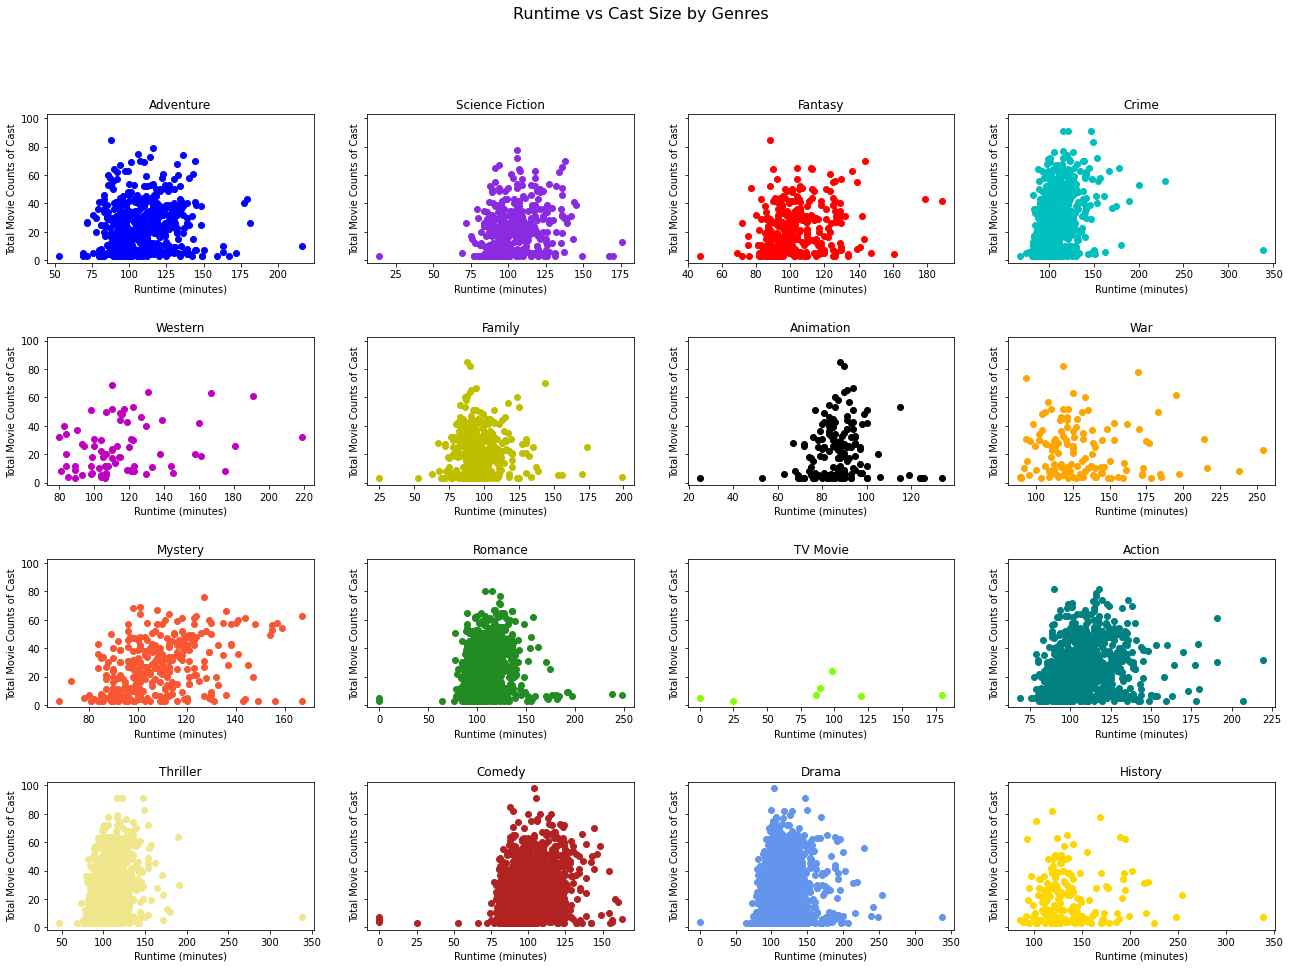

In [43]:
fig, ax = plt.subplots(4,4, figsize = (22,15), sharey = True)
fig.suptitle('Runtime vs Cast Size by Genres', fontsize=16)
plt.subplots_adjust(hspace=0.5)

color_list = ["b", "blueviolet", "r", "c", "m", "y", "k", "orange",
              "#F95633","forestgreen","chartreuse","teal","khaki","firebrick","cornflowerblue","gold"]
i = 0
j = 0
k = 0
for i in range(4):
  for j in range(4):
    temp_df = X_train_clean[X_train_clean[genre_list[k]] == True]
    ax[i][j].plot(temp_df["runtime"], temp_df["cast_movie_count"],
                  marker='.', linestyle='', ms=12, label=genre, c=color_list[(k) % 16])
    ax[i][j].set_title(genre_list[k])
    ax[i][j].set_xlabel("Runtime (minutes)")
    ax[i][j].set_ylabel("Total Movie Counts of Cast")
    k+=1

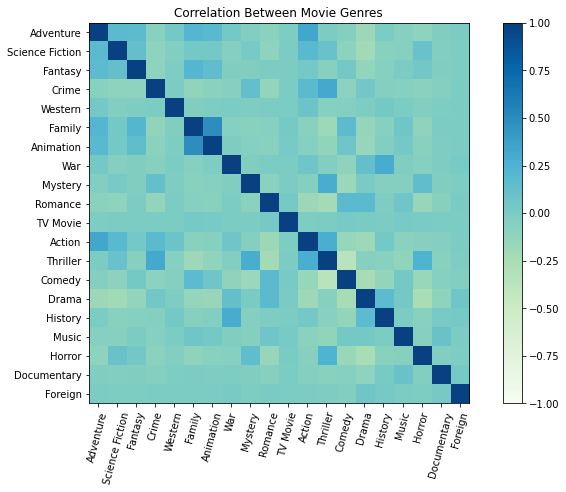

In [44]:
corrs=X_train_clean[genre_list].corr()
fig= plt.figure(figsize=(12,7))
plt.imshow(corrs, cmap="GnBu", vmin = -1, vmax = 1)
plt.colorbar()
plt.title("Correlation Between Movie Genres")
plt.xticks(range(len(corrs)),corrs.columns, rotation=75)
plt.yticks(range(len(corrs)),corrs.index)
plt.show()

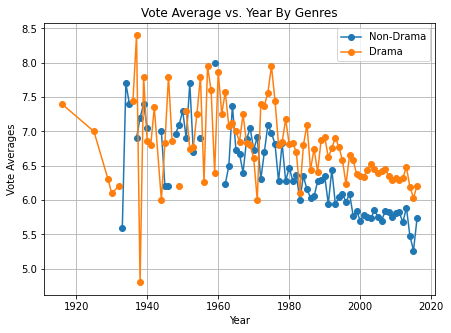

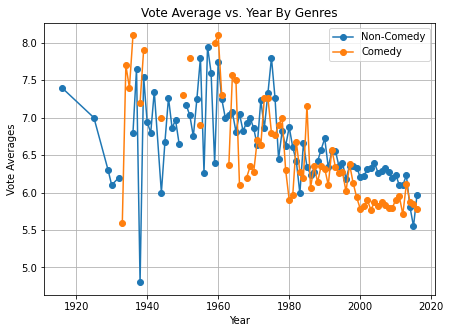

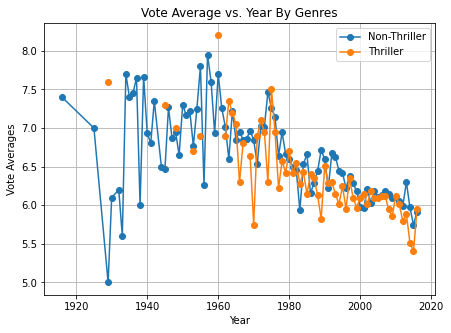

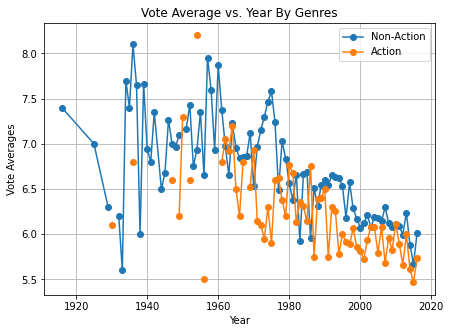

In [45]:
mini_genre_list = [["Drama", "Comedy"], ["Thriller", "Action"]]
for a in range(2):
  for b in range(2):
    groups = X_train_clean.groupby(by = ["year",mini_genre_list[a][b]])
    ax[a][b] = groups["vote_average"].mean().unstack().plot(figsize = (7, 5), grid = True,
                                                  xlabel="Year", ylabel = "Vote Averages",
                                                  marker = "o",
                                                  title = "Vote Average vs. Year By Genres")
    ax[a][b].legend(["Non-"+mini_genre_list[a][b],mini_genre_list[a][b]])
plt.show()

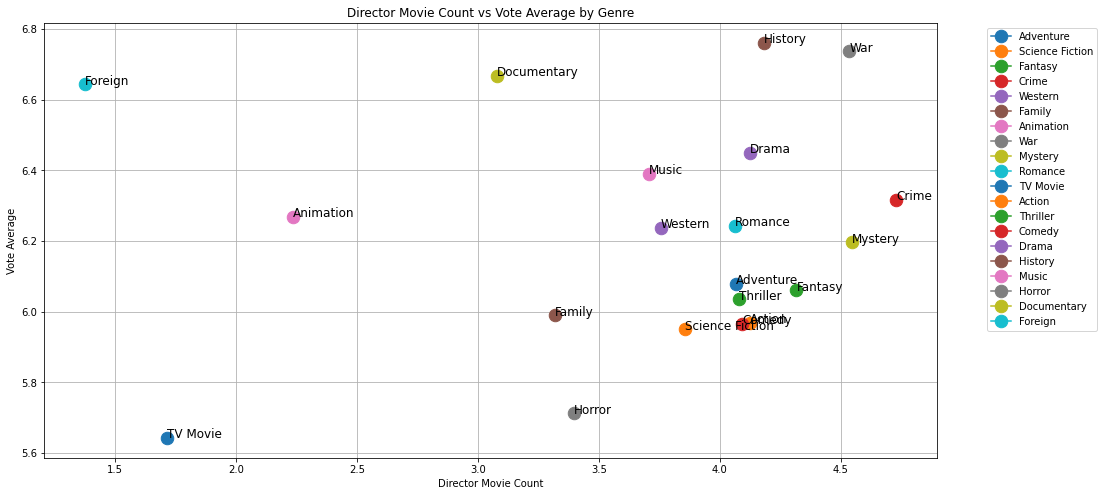

In [46]:
fig, ax = plt.subplots(1, 1, figsize = (16,8))
for genre in genre_list:
    temp_df = X_train_clean[X_train_clean[genre] == True]
    genre_group = temp_df.groupby(genre)[["director_movie_count", "vote_average"]].mean()
    genre_group.plot(x="director_movie_count", y="vote_average", kind="line", ax=ax, marker='.', ms=25, label=genre)
    ax.annotate(genre, (genre_group.director_movie_count, genre_group.vote_average), xycoords = "data", fontsize = 12)

ax.set_title("Director Movie Count vs Vote Average by Genre")
ax.set_xlabel("Director Movie Count")
ax.set_ylabel("Vote Average")

ax.grid(True)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [47]:
X_train_num= X_train.drop(["genres", "keywords","title","director","cast_1","cast_2","cast_3","production_companies_1"], axis = 1)
X_train_num = X_train_num.drop(genre_list, axis=1)
     

In [48]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_num_wout_id = scaler.fit_transform(X_train_num.drop(columns=["movie_id"]))
X_train_num_wout_id = pd.DataFrame(X_train_num_wout_id, 
                                   columns = X_train_num.drop(columns=["movie_id"]).columns, index = X_train_num.index)
     

In [49]:
kmeanModel = KMeans(n_clusters=30)
kmeanModel.fit(X_train_num_wout_id)
cluster_type = "KMeans_Cluster"
X_train_num = X_train_num_wout_id.join(X_train_num["movie_id"])               
X_train_num[cluster_type] = kmeanModel.labels_
X_train_num[cluster_type].sample(n=10)

e = []
def fi(group):
    a = pd.DataFrame(group)
    b = pd.DataFrame(a[cluster_type].value_counts())
    d = a.index 
    c = [a['movie_id'][d[0]],int(b.idxmax())]
    e.append(c)

X_train_num.groupby("movie_id").apply(lambda x: fi(x))

e = pd.DataFrame(e)
e.rename(columns = {0:'movie_id',1:cluster_type},inplace=True)
e.drop_duplicates(inplace=True)

new_data = pd.merge(e , X_train , how='outer', on='movie_id')

In [50]:
from sklearn.metrics import silhouette_score
label=kmeanModel.predict(X_train_num_wout_id)
print(f'Silhouette Score(n=30): {silhouette_score(X_train_num_wout_id, label)}')

Silhouette Score(n=30): 0.12215065720899418


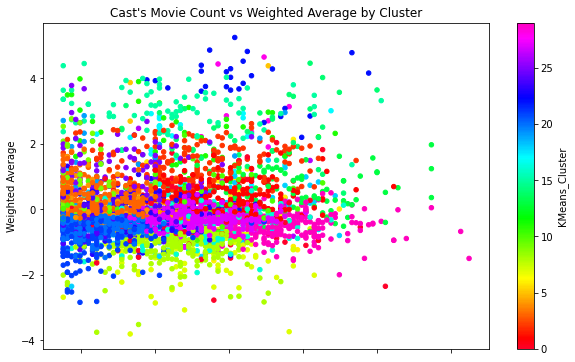

In [51]:
X_train_num.plot.scatter('cast_movie_count', 'weighted_average', c=cluster_type, colormap='gist_rainbow',
                         title="Cast's Movie Count vs Weighted Average by Cluster", figsize=(10,6)).set(xlabel="Cast's Movie Count", ylabel="Weighted Average");
     

In [4]:
movies=pd.read_csv('tmdb_5000_movies.csv')
credits=pd.read_csv('tmdb_5000_credits.csv')
movies=movies.merge(credits,on='title')

In [5]:
movies=movies[['movie_id','title','overview','genres','keywords','cast','crew']]

In [6]:
movies.isnull().sum()

movie_id    0
title       0
overview    3
genres      0
keywords    0
cast        0
crew        0
dtype: int64

In [7]:
movies.dropna(inplace=True)

In [8]:
movies.duplicated().sum()

0

In [9]:
movies.iloc[0].genres

'[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]'

In [10]:
def convert(obj):
    L=[]
    for i in ast.literal_eval(obj):
        L.append(i['name'])
    return L

In [11]:
import ast
ast.literal_eval('[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]')

[{'id': 28, 'name': 'Action'},
 {'id': 12, 'name': 'Adventure'},
 {'id': 14, 'name': 'Fantasy'},
 {'id': 878, 'name': 'Science Fiction'}]

In [12]:
movies['genres']=movies['genres'].apply(convert)
movies['keywords']=movies['keywords'].apply(convert)

In [15]:
def convert3(obj):
    L=[]
    counter=0
    for i in ast.literal_eval(obj):
        if counter!=3:
            L.append(i['name'])
            counter+=1
        else:
              break
    return L

In [16]:
movies['cast']=movies['cast'].apply(convert3)

In [17]:
def fetch_director(obj):
    L=[]
    for i in ast.literal_eval(obj):
        if i['job']=='Director':
            L.append(i['name'])
            break
    return L
            

In [18]:
movies['crew']=movies['crew'].apply(fetch_director)
movies['overview']=movies['overview'].apply(lambda x:x.split())
movies['genres']=movies['genres'].apply(lambda x:[i.replace(" ","") for i in x])
movies['keywords']=movies['keywords'].apply(lambda x:[i.replace(" ","") for i in x])
movies['cast']=movies['cast'].apply(lambda x:[i.replace(" ","") for i in x])
movies['crew']=movies['crew'].apply(lambda x:[i.replace(" ","") for i in x])
movies['tags']=movies['overview'] + movies['genres'] + movies['keywords'] + movies['cast'] + movies['crew'] 
new_df=movies[['movie_id','title','tags']]

In [19]:
new_df.head()

,movie_id,title,tags
0,19995,Avatar,"[In, the, 22nd, century,, a, paraplegic, Marin..."
1,285,Pirates of the Caribbean: At World's End,"[Captain, Barbossa,, long, believed, to, be, d..."
2,206647,Spectre,"[A, cryptic, message, from, Bond’s, past, send..."
3,49026,The Dark Knight Rises,"[Following, the, death, of, District, Attorney..."
4,49529,John Carter,"[John, Carter, is, a, war-weary,, former, mili..."


In [20]:
new_df['tags']=new_df['tags'].apply(lambda x:" ".join(x))

In [21]:
new_df.head()

,movie_id,title,tags
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di..."
1,285,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha..."
2,206647,Spectre,A cryptic message from Bond’s past sends him o...
3,49026,The Dark Knight Rises,Following the death of District Attorney Harve...
4,49529,John Carter,"John Carter is a war-weary, former military ca..."


In [22]:
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(max_features=5000,stop_words='english')
vector_1=cv.fit_transform(new_df['tags']).toarray()

In [23]:
tfid = TfidfVectorizer(max_features=5000,stop_words='english')
vector_2 = tfid.fit_transform(new_df['tags'])

In [24]:
cosine_sim = cosine_similarity(vector_1, vector_2)
cosine_sim

array([[0.97157672, 0.04336286, 0.02710426, ..., 0.01195978, 0.01323032,
        0.        ],
       [0.04547653, 0.97208102, 0.02834631, ..., 0.0221125 , 0.        ,
        0.        ],
       [0.0274078 , 0.02733153, 0.97565877, ..., 0.02104128, 0.        ,
        0.        ],
       ...,
       [0.01191071, 0.02099823, 0.02072286, ..., 0.96598229, 0.04603759,
        0.03769144],
       [0.01331657, 0.        , 0.        , ..., 0.04652868, 0.97837555,
        0.02936267],
       [0.        , 0.        , 0.        , ..., 0.04131933, 0.03184916,
        0.98165561]])

In [25]:
sorted(list(enumerate(cosine_sim[0])),reverse=True,key=lambda x:x[1])

[(0, 0.971576716518182),
 (539, 0.2161241119546376),
 (582, 0.21213679720826706),
 (4405, 0.21095964052449268),
 (3730, 0.20308278563280197),
 (260, 0.201390371361526),
 (3608, 0.1961748382671298),
 (1920, 0.19524462530318035),
 (47, 0.18848279487258948),
 (942, 0.18755579739804326),
 (83, 0.18707639582996766),
 (1216, 0.18686673512149804),
 (2409, 0.18359304745207314),
 (507, 0.1792796750785906),
 (74, 0.1778203134221099),
 (3538, 0.17465207781121306),
 (1194, 0.17265223319440887),
 (2204, 0.16833042402773798),
 (1201, 0.16765409415051902),
 (1329, 0.16706370256027858),
 (1537, 0.16699546330529685),
 (1444, 0.16634157861944104),
 (2971, 0.16334564793353276),
 (1204, 0.16122296431158678),
 (3162, 0.159768581235608),
 (4192, 0.15882740075769217),
 (322, 0.158379640551283),
 (2333, 0.1573231490374789),
 (1275, 0.15020305368756318),
 (466, 0.14946421444110292),
 (3327, 0.14905976802270915),
 (300, 0.14876053657913785),
 (184, 0.1486164141475671),
 (972, 0.1479892924945997),
 (557, 0.14776

In [29]:
def recommend(movie):
    movie_index = new_df[new_df['title'] == movie].index[0]
    distances = cosine_sim[movie_index]
    movies_list = sorted(list(enumerate(distances)), reverse=True, key=lambda x: x[1])[1:6]
    recommended_movies = []
    for i in movies_list:
        recommended_movies.append(new_df.iloc[i[0]].title)
    return recommended_movies


In [30]:
 recommend('Batman Begins')

['The Dark Knight',
 'The Dark Knight Rises',
 'Batman',
 'Batman',
 'Batman v Superman: Dawn of Justice']

In [32]:
def calculate_accuracy(test_set):
    total_precision = 0
    total_recall = 0
    total_movies = len(test_set)
    
    for movie, actual_similar_movies in test_set.items():
        recommended_movies = recommend(movie)  # Use your recommendation function
        recommended_set = set(recommended_movies)
        actual_set = set(actual_similar_movies)
        
        # Calculate precision and recall
        precision = len(recommended_set.intersection(actual_set)) / len(recommended_set)
        recall = len(recommended_set.intersection(actual_set)) / len(actual_set)
        
        total_precision += precision
        total_recall += recall
    
    # Calculate average precision and recall
    avg_precision = total_precision / total_movies
    avg_recall = total_recall / total_movies
    
    # F1-score
    f1_score = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall)
    
    return avg_precision, avg_recall, f1_score

# Example test set (replace this with your actual test set)
test_set = {
   "Batman Begins": ["The Dark Knight", "Inception", "Interstellar"]
    
}

# Calculate accuracy
precision, recall, f1 = calculate_accuracy(test_set)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Precision: 0.25
Recall: 0.3333333333333333
F1-score: 0.28571428571428575


In [136]:
import pickle
pickle.dump(new_df.to_dict(),open('movie_dict.pkl','wb'))
pickle.dump(cosine_sim,open('similarity.pkl','wb'))